In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/vindr-mammo-furkanaktay

/content/drive/MyDrive/vindr-mammo-furkanaktay


In [26]:
!git clone https://github.com/sunsmarterjie/yolov12

fatal: destination path 'yolov12' already exists and is not an empty directory.


In [27]:
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.3/flash_attn-2.7.3+cu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl
%cd yolov12

--2025-12-03 23:36:21--  https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.3/flash_attn-2.7.3+cu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/494232964/b7fb7022-424c-4ac2-b46b-a41f386edaa5?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T00%3A11%3A19Z&rscd=attachment%3B+filename%3Dflash_attn-2.7.3%2Bcu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-03T23%3A11%3A18Z&ske=2025-12-04T00%3A11%3A19Z&sks=b&skv=2018-11-09&sig=Z%2Fciwn6mdPV%2BRdxKvLWPblcxlGsq4lObcx1Yg9PvHYU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcm

In [28]:
!pip install -r requirements.txt
!pip install -e .

ERROR: flash_attn-2.7.3+cu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl is not a supported wheel on this platform.
Obtaining file:///content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.63-0.editable-py3-none-any.whl size=20270 sha256=c08a936349ed80825b08dc38602ba8fef0aa187ba35994c56ae78a7f799edcc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnra4wh5/wheels/2d/4e/8d/d9c3fd4b3211242b9a63b3d208a8dc690a1cbd9fb07bd70bb2
Successfully built ultralytics
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.63
    Uninstalling ultralytics-8.3.63:
      Successfully uninstalled ultralytics-8.3.63


In [1]:
from ultralytics import YOLO

model = YOLO('yolov12l.pt')

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 250MB/s]



image 1/1 /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/test.jpg: 448x640 2 bowls, 83.3ms
Speed: 2.3ms preprocess, 83.3ms inference, 120.8ms postprocess per image at shape (1, 3, 448, 640)


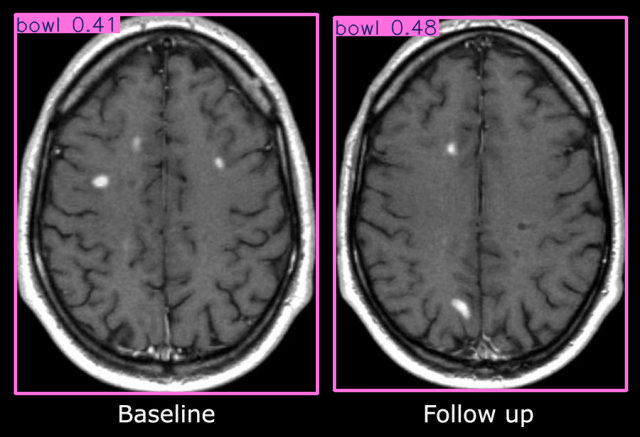

In [2]:
result = model('/content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/test.jpg')
result[0].show()

In [3]:
from pathlib import Path

labels_root = Path("/content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels")

def fix_labels_single_class(labels_root: Path):
    n_files = 0
    n_lines = 0
    for p in labels_root.rglob("*.txt"):
        n_files += 1
        new_lines = []
        with open(p, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # bozuk satırı atla

                # sınıf id'sini 0'a sabitle
                cls = 0
                x, y, w, h = map(float, parts[1:])

                # koordinatlar [0,1] aralığında mı kontrol et
                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                    continue  # normalleştirilmemiş / bozuk box ise atla

                new_line = f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
                new_lines.append(new_line)
                n_lines += 1

        # dosyayı yeni, temiz satırlarla yeniden yaz
        with open(p, "w") as f:
            f.write("\n".join(new_lines))

    print(f"Fixed {n_files} label files, total {n_lines} boxes.")

fix_labels_single_class(labels_root)

Fixed 40 label files, total 81 boxes.


In [4]:
from pathlib import Path

labels_root = Path("/content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels")

def scan_and_fix_labels(root):
    print("scanning YOLO label files...\n")
    for txt in root.rglob("*.txt"):
        with open(txt, "r") as f:
            lines = f.read().strip().splitlines()

        new_lines = []
        for idx, ln in enumerate(lines):
            parts = ln.strip().split()
            if len(parts) != 5:
                print(f"invalid line format in {txt}: '{ln}'")
                continue

            # sınıf id 0a sabitlenir
            cls = 0
            try:
                x, y, w, h = map(float, parts[1:])
            except:
                print(f"non-numeric values in {txt}: {ln}")
                continue

            # değerler 0,1 aralığında olmalı
            if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                print(f"out of range bbox in {txt}: {x, y, w, h}")
                continue

            new_lines.append(f"0 {x} {y} {w} {h}")

        # yeni dosya yaz
        with open(txt, "w") as f:
            f.write("\n".join(new_lines))

    print("\nlabel scan and repair completed!")

scan_and_fix_labels(labels_root)

🔍 Scanning YOLO label files...


✔ Label scan + repair completed!


In [5]:
from ultralytics import YOLO

model = YOLO('yolov12n.yaml')

# Train the model
results = model.train(
  data='/content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/data.yaml',
  epochs=20,
  batch=16,
  imgsz=640,
  scale=0.5,  # S:0.9; M:0.9; L:0.9; X:0.9
  mosaic=1.0,
  mixup=0.0,  # S:0.05; M:0.15; L:0.15; X:0.2
  copy_paste=0.1,  # S:0.15; M:0.4; L:0.5; X:0.6
  device="0",
)

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.yaml, data=/content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, reti

100%|██████████| 5.26M/5.26M [00:00<00:00, 98.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels/train... 36 images, 9 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 100.37it/s]

train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/001ade2a3cb53fd808bd2856a0df5413.png: 6 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/1a1d13244aaafa6a12988c4e1d3efe5b.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/232f33051c77bd6ce2d185aafe9471a3.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/4274a76dcc9e28508eff58acc103dc73.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/6c89a90416411eecf56e5ea1fff2a1e2.png: 4 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/train/a6bb433105ba47d9cdc9f368a8c261a9.png: 2 duplicate labels removed
train: WARNING ⚠️ /con

train: New cache created: /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels/val... 4 images, 1 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 20.79it/s]

val: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/val/4785b56fa6a49b939087d0544a04e65f.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/images/val/a41a04883364dff4df3b28905809d335.png: 1 duplicate labels removed
val: New cache created: /content/drive/MyDrive/vindr-mammo-furkanaktay/data/processed/yolo/labels/val.cache


Plotting labels to /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.65G        4.1      7.803      4.245         27        640: 100%|██████████| 3/3 [00:24<00:00,  8.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.58G      4.146          9      4.269         17        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.58G      3.852      6.517      4.263         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.58G      4.135      7.195      4.245         21        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.58G      3.719      6.988      4.203         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.61G      3.794       6.71      4.186         18        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.62G      3.872       6.45      4.209         22        640: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.62G      4.381      6.665       4.17         23        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.63G      4.628      7.312      4.195         22        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.62G      4.126      8.085      4.156         13        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

                   all          5          4          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.62G      3.548      7.454      4.154         13        640: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.62G      3.901      7.435      4.108         15        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.62G      3.093      7.862      4.116         15        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.62G      3.951      8.846      4.103         13        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.62G       4.12       8.08      4.072         15        640: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G      3.307      7.053      4.063         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.62G      3.412      7.115      4.045         17        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.62G      3.203      7.375      4.044         16        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.62G      3.502      7.415      4.026         11        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all          5          4          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.62G      4.218      10.76      4.022         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all          5          4          0          0          0          0



20 epochs completed in 0.025 hours.
Optimizer stripped from /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3/weights/last.pt, 5.4MB
Optimizer stripped from /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3/weights/best.pt, 5.4MB

Validating /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,539 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

                   all          5          4          0          0          0          0


Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/drive/MyDrive/vindr-mammo-furkanaktay/yolov12/runs/detect/train3
